In [1]:
!pip install imageio

Looking in indexes: https://mirrors6.bfsu.edu.cn/pypi/web/simple


In [1]:
from model.utils import setup_training
import gymnasium as gym
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import imageio
from model.models import DiscreteActor

In [2]:
# Configuration and weight paths
config_path = '../config/CartPole.yaml'  # Path to the configuration file
weight_path = './weights/CartPole_actor.pt'  # Path to the pre-trained model weights

# Set the device to CUDA if available, otherwise use CPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
args = setup_training(config_path)

env = gym.make(args.env_name, render_mode="rgb_array")
observation, info = env.reset(seed=args.seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

actor = DiscreteActor(n_wires=args.n_wires,
                                       n_blocks=args.n_blocks,
                                       input_dim=state_dim,
                                       output_dim=action_dim,
                                       ini_method=args.ini_method).to(DEVICE)

actor.load_state_dict(torch.load(weight_path))  # # Load the pre-trained model weights

/tmp/ipykernel_12229/2115950376.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load(weight_path))  # # Load the pre-trained model weights


<All keys matched successfully>

In [4]:
frames = []

done = False
total_reward = 0

while not done:
    frame = env.render()
    frames.append(frame)

    s = torch.tensor(observation, dtype=torch.float32, device=DEVICE).unsqueeze(0)

    with torch.no_grad():
        dist = Categorical(probs=actor(s))
        action = dist.sample().cpu().item()

    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward

env.close()
print(f"Total Reward: {total_reward}")


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Total Reward: 500.0


In [5]:
# Save the recorded frames as a GIF
gif_path = "env_inference.gif"
imageio.mimsave(gif_path, frames, fps=30)

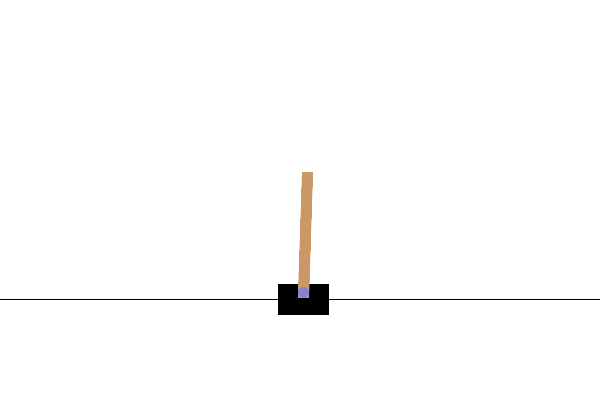

In [6]:
# Display the GIF in Jupyter Notebook
from IPython.display import Image
Image(gif_path)